### Introduction

Powered by theoretical advancement, big data and computer hardware, recent advances in autoregressive large language models (LLMs) have shown remarkable capacity to generate and understand complex human-like language. Yet, these models are typically trained on general corpora and usually struggle with domains like geography, which is inherently local, contextual, and interdisciplinary, shaped by diverse social, environmental, and political processes. (Janowicz et al., 2025). On the other hand, via proper and systematic prompts, including providing a few examples regarding the domain specific tasks, giving LLMs time to conduct chain-of-thought thinking, being task explicit etc., it has been proved that they can generally adapt to such tasks well (OpenAI, 2022; Bhandari et al., 2023; Majic et al., 2024). In this experiment, I use several popular LLMs to extract knowledge from unstructured climate mobility literature, on the one hand to apply them as advances in NLP to efficiently and precisely conduct downstream tasks, including literature review and domain specific graph foundation model construction for reliable, transparent and explainable retrieval and reasoning, and on the other hand as AI benchmarking, to demonstrate how domain-specific, knowledge-rich contexts can be understood better by AI, and test their geo-alignment.

In this experiment, I take the review paper from Borderon et al., 2019 and their coding system as ground truth, to benchmark 3 different LLMs, with 0-shot and 3-shot learning, as well as different temperatures. For each task I run 20 times for the comparison of accuracy.

### Libraries

In [1]:
from openai import OpenAI, RateLimitError, APIError, APITimeoutError, AuthenticationError, BadRequestError, NotFoundError
import google.generativeai as genai
import tiktoken

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# from multiprocessing import Pool
import time
import os
import ast

### Layout

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_seq_items', None)

### Data

In [3]:
literature = np.load('literature.npy', allow_pickle=True).item()
example = np.load('example.npy', allow_pickle=True).item()

### General commands for getting response

In [4]:
text = "{{'Qualitative method': '1', 'Quantitative method': '1', 'Socio-demo-economic data': '1', 'Environmental data': '1', \
'Individuals': '0', 'Households': '1', 'Subnational groups': '1', 'National groups': '0', 'International groups': '0', \
'Urban': '0', 'Rural': '1', 'Time frame considered': '1', 'Foresight': '0', \
'Rainfall pattern / Variability': '1', 'Temperature change': '0', 'Food scarcity / Famine / Food security ': '1', 'Drought / Aridity / Desertification': '1', \
'Floods': '1', 'Erosion / Soil fertilty / Land degradation / Deforestation / Salinisation': '1', 'Self assessement / Perceived environment': '1', \
'Labour migration': '1', 'Marriage migration': '0', 'Refugees': '0', 'International migration': '0', 'Cross-border migration': '0', 'Internal migration': '1', \
'Rural to urban': '1', 'Rural to rural': '1', 'Circular / Seasonal': '1', 'Long distance': '1', 'Short distance': '0', 'Temporal': '1', 'Permanent': '0', \
'Age': '1', 'Gender': '0', 'Ethnicity / Religion': '0'}}"
enc = tiktoken.encoding_for_model("gpt-4.1-mini")
MAX_TOKEN = len(enc.encode(text))

In [5]:
def api_def(provider):
    # API keys are hidden in another file
    with open('api.txt', 'r', encoding='utf-8') as file:
        lines = [line.strip() for line in file.readlines()]

        # Different LLMs need different kinds of command
        if provider == 'chatgpt':
            client = OpenAI(api_key=str(lines[0]), base_url="https://api.openai.com/v1")
            return client
        
        elif provider == 'deepseek':
            client = OpenAI(api_key=str(lines[1]), base_url="https://api.deepseek.com")
            return client
        
        elif provider == 'gemini':
            genai.configure(api_key=str(lines[2]))

In [42]:
def get_completion(prompt, provider, model, temperature):
    messages = [{"role": "system", "content": "You are a research assistant conducting a systematic literature review on climate mobility. \
    Your task is to read the provided text and classify it according to the given properties with binary codes. \
    Do not include explanations, personal opinions or provide unrelated meta-comments in the answer. Provide only the classification results."},
               {"role": "user", "content": prompt}]

    # Different LLMs need different kinds of command
    if provider == 'gpt':
        client = api_def('chatgpt')
        response = client.responses.create(
            model=model,
            input=messages,
            temperature=temperature,
            max_output_tokens = round(MAX_TOKEN + 3)
        )
        return response.output_text
        
    elif provider == 'ds':
        client = api_def('deepseek')
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            temperature=temperature,
            max_tokens = round(MAX_TOKEN * 1.2)
        )
        return response.choices[0].message.content

    elif provider == 'gemini':
        api_def('gemini')
        model_gemini = genai.GenerativeModel(model)
        response = model_gemini.generate_content(
            prompt,
            generation_config={"temperature": temperature, "max_output_tokens": round(MAX_TOKEN * 1.3)}
        )
        return response.text        

### Prompt and response processing

In [7]:
CONTEXT = f"""
We are conducting a systematic review of climate mobility literature. For each paper, your task is to assign some binary codes, namely '0' or '1', \
for the specific indicators that I will provide, to categorize the paper across multiple dimensions for later analysis. \n

While reviewing a paper, evaluate *only the content of this paper*. Do not use information from any other paper. Do not infer missing information from \
past tasks or earlier papers. Focus primarily on the abstract, data/methods, results, and conclusions sections. \
Do not rely on introduction, state-of-the-art, related works, or motivation sections, especially when they describe other researchers’ work. \
Only use information from those sections if they explicitly describe what *this paper* does. \n

For each index, output one and only one character: '0' (for 'No') or '1' (Yes), according to the concrete explanation below. Do not provide explanations. \
Each indicator is independent, do not infer one indicator based on another. Please follow strictly the format I will specify later. \
When information is missing or unclear, just assign '0'.
"""

In [48]:
ZERO_SHOT_PROMPT = f"""

<Prof>: 
{CONTEXT} \n

The following 36 indicators will be used to categorize each paper, regarding its content: \n
a. Methods used for data analysis (refers only to analytical methods, not methods for data collection) (2 indicators): 1. 'Qualitative method' and \
2. 'Quantitative method'. Note that a paper may use both, one, or neither. \n
b. Types of data included for analysis (2 indicators): 3. 'Socio-demo-economic data' ('demo' means 'demographic') and 4. 'Environmental data'. Please \
only assign '1' when a type of data is used (no matter how data is collected), while only mentioning an aspect of this paper doesn't count. \
Note that a paper can include both, one, or neither. \n
c. Focal demographic units of analysis (refers to the units of analysis, not research areas) (5 indicators): 5. 'Individuals', 6. 'Households', \
7. 'Subnational groups' (like community, province, etc.), 8. 'National groups', 9. 'International groups'. Note that a paper can focus on several, \
one or none of them. \n
d. Research location types (refers to the places where research took place, not where people move to) (2 indicators): 10. 'Urban', 11. 'Rural'. \
A study may focus on both, one, or neither. \n
e. Temporal aspects (2 indicators): 12. 'Time frame considered' (e.g., temporal analysis was used), 13. 'Foresight' (e.g., forecast, prediction, and \
future perspectives was/were addressed). A paper may consider both, one, or neither of them. \n
f: Environmental stressors as variables (only give '1' when a stressor is explicitly analysed, while only mentioning without evidence doesn't count) \
(7 indicators): 14. 'Rainfall pattern / Variability', 15. 'Temperature change', 16. 'Food scarcity / Famine / Food security', \
17. 'Drought / Aridity / Desertification', 18. 'Floods', 19. 'Erosion / Soil fertility / Land degradation / Deforestation / Salinisation', \
20. 'Self assessement / Perceived environment '. Note that indicator 20 indicates that the above stressors measured via human perception were \
included in the paper, no matter if data from observation was included. For indicators 14 to 19, a paper may include multiple, one, or none. \n 
g: Types of migration discussed (8 indicators): 21. 'Labour migration' (migration related to work), 22. 'Marriage migration', 23. 'Refugees', \
24. 'International migration', 25. 'Cross-border migration' (compared to 'International migration' which indicates those migration with longer \
distance, 'Cross-border migration' denotes those migration that people move only from one nation to an adjacent one), 26. 'Internal migration' (those \
migration within one single nation), 27. 'Rural to urban', 28. 'Rural to rural'. Note that a paper might contain multiple, one, or none of them. \n
h: Mobility/migration patterns discussed (5 indicators): 29. 'Circular / Seasonal', 30. 'Long distance', 31. 'Short distance', 32. 'Temporal' \
(migrants may come back), and 33. 'Permanent' (migrants will not come back). Note that a paper can also consider multiple, one, or none of them. \n
i: Specific demographic characteristics as variables (only mentioning without serving as variables doesn't count) (3 indicators): 34. 'Age', \
35. 'Gender', 36. 'Ethnicity / Religion'. Note that a paper can also consider multiple, one, or none of them. \n

Always output the result in the following Python Dictionary structure with identical order, with each blank replaced by 0 or 1 only, and no extra text: \n
{{'Qualitative method': '_', 'Quantitative method': '_', 'Socio-demo-economic data': '_', 'Environmental data': '_', \
'Individuals': '_', 'Households': '_', 'Subnational groups': '_', 'National groups': '_', 'International groups': '_', \
'Urban': '_', 'Rural': '_', 'Time frame considered': '_', 'Foresight': '_', \
'Rainfall pattern / Variability': '_', 'Temperature change': '_', 'Food scarcity / Famine / Food security ': '_', 'Drought / Aridity / Desertification': '_', \
'Floods': '_', 'Erosion / Soil fertility / Land degradation / Deforestation / Salinisation': '_', 'Self assessement / Perceived environment': '_', \
'Labour migration': '_', 'Marriage migration': '_', 'Refugees': '_', 'International migration': '_', 'Cross-border migration': '_', 'Internal migration': '_', \
'Rural to urban': '_', 'Rural to rural': '_', 'Circular / Seasonal': '_', 'Long distance': '_', 'Short distance': '_', 'Temporal': '_', 'Permanent': '_', \
'Age': '_', 'Gender': '_', 'Ethnicity / Religion': '_'}}
"""

In [9]:
ONE_SHOT_PROMPT = f"""

{ZERO_SHOT_PROMPT} \n

Now please try to code the following paper: \n
\"\"\"{example[0]}\"\"\"
\n
<research assistant>: OK, here is my result: \n
{{'Qualitative method': '1', 'Quantitative method': '1', 'Socio-demo-economic data': '1', 'Environmental data': '1', \
'Individuals': '0', 'Households': '1', 'Subnational groups': '1', 'National groups': '0', 'International groups': '0', \
'Urban': '0', 'Rural': '1', 'Time frame considered': '1', 'Foresight': '0', \
'Rainfall pattern / Variability': '1', 'Temperature change': '0', 'Food scarcity / Famine / Food security ': '1', 'Drought / Aridity / Desertification': '1', \
'Floods': '1', 'Erosion / Soil fertility / Land degradation / Deforestation / Salinisation': '1', 'Self assessement / Perceived environment': '1', \
'Labour migration': '1', 'Marriage migration': '0', 'Refugees': '0', 'International migration': '0', 'Cross-border migration': '0', 'Internal migration': '1', \
'Rural to urban': '1', 'Rural to rural': '1', 'Circular / Seasonal': '1', 'Long distance': '1', 'Short distance': '0', 'Temporal': '1', 'Permanent': '0', \
'Age': '1', 'Gender': '0', 'Ethnicity / Religion': '0'}}
"""

In [10]:
THREE_SHOT_PROMPT = f"""

{ZERO_SHOT_PROMPT} \n

Now please try to code the following 3 papers: \n
\"\"\"{example}\"\"\"
\n
<research assistant>: OK, here is my result: \n
{{'Qualitative method': '1', 'Quantitative method': '1', 'Socio-demo-economic data': '1', 'Environmental data': '1', \
'Individuals': '0', 'Households': '1', 'Subnational groups': '1', 'National groups': '0', 'International groups': '0', \
'Urban': '0', 'Rural': '1', 'Time frame considered': '1', 'Foresight': '0', \
'Rainfall pattern / Variability': '1', 'Temperature change': '0', 'Food scarcity / Famine / Food security ': '1', 'Drought / Aridity / Desertification': '1', \
'Floods': '1', 'Erosion / Soil fertility / Land degradation / Deforestation / Salinisation': '1', 'Self assessement / Perceived environment': '1', \
'Labour migration': '1', 'Marriage migration': '0', 'Refugees': '0', 'International migration': '0', 'Cross-border migration': '0', 'Internal migration': '1', \
'Rural to urban': '1', 'Rural to rural': '1', 'Circular / Seasonal': '1', 'Long distance': '1', 'Short distance': '0', 'Temporal': '1', 'Permanent': '0', \
'Age': '1', 'Gender': '0', 'Ethnicity / Religion': '0'}}, \
{{'Qualitative method': '0', 'Quantitative method': '1', 'Socio-demo-economic data': '1', 'Environmental data': '1', \
'Individuals': '0', 'Households': '1', 'Subnational groups': '0', 'National groups': '0', 'International groups': '0', \
'Urban': '1', 'Rural': '1', 'Time frame considered': '1', 'Foresight': '1', \
'Rainfall pattern / Variability': '1', 'Temperature change': '1', 'Food scarcity / Famine / Food security ': '0', 'Drought / Aridity / Desertification': '0', \
'Floods': '0', 'Erosion / Soil fertility / Land degradation / Deforestation / Salinisation': '0', 'Self assessement / Perceived environment': '0', \
'Labour migration': '1', 'Marriage migration': '0', 'Refugees': '0', 'International migration': '1', 'Cross-border migration': '0', 'Internal migration': '1', \
'Rural to urban': '1', 'Rural to rural': '0', 'Circular / Seasonal': '1', 'Long distance': '1', 'Short distance': '1', 'Temporal': '1', 'Permanent': '1', \
'Age': '0', 'Gender': '0', 'Ethnicity / Religion': '0'}}, \
{{'Qualitative method': '0', 'Quantitative method': '1', 'Socio-demo-economic data': '1', 'Environmental data': '1', \
'Individuals': '1', 'Households': '1', 'Subnational groups': '0', 'National groups': '0', 'International groups': '0', \
'Urban': '0', 'Rural': '1', 'Time frame considered': '1', 'Foresight': '0', \
'Rainfall pattern / Variability': '0', 'Temperature change': '0', 'Food scarcity / Famine / Food security ': '0', 'Drought / Aridity / Desertification': '0', \
'Floods': '0', 'Erosion / Soil fertility / Land degradation / Deforestation / Salinisation': '1', 'Self assessement / Perceived environment': '0', \
'Labour migration': '1', 'Marriage migration': '1', 'Refugees': '0', 'International migration': '0', 'Cross-border migration': '0', 'Internal migration': '1', \
'Rural to urban': '1', 'Rural to rural': '0', 'Circular / Seasonal': '1', 'Long distance': '0', 'Short distance': '1', 'Temporal': '1', 'Permanent': '1', \
'Age': '1', 'Gender': '1', 'Ethnicity / Religion': '0'}}
"""

In [11]:
THREE_SHOT_SEPARATE_PROMPT = f"""

{ZERO_SHOT_PROMPT} \n

Now please try to code the following paper: \n
\"\"\"{example[0]}\"\"\"
\n
<research assistant>: OK, here is my result: \n
{{'Qualitative method': '1', 'Quantitative method': '1', 'Socio-demo-economic data': '1', 'Environmental data': '1', \
'Individuals': '0', 'Households': '1', 'Subnational groups': '1', 'National groups': '0', 'International groups': '0', \
'Urban': '0', 'Rural': '1', 'Time frame considered': '1', 'Foresight': '0', \
'Rainfall pattern / Variability': '1', 'Temperature change': '0', 'Food scarcity / Famine / Food security ': '1', 'Drought / Aridity / Desertification': '1', \
'Floods': '1', 'Erosion / Soil fertility / Land degradation / Deforestation / Salinisation': '1', 'Self assessement / Perceived environment': '1', \
'Labour migration': '1', 'Marriage migration': '0', 'Refugees': '0', 'International migration': '0', 'Cross-border migration': '0', 'Internal migration': '1', \
'Rural to urban': '1', 'Rural to rural': '1', 'Circular / Seasonal': '1', 'Long distance': '1', 'Short distance': '0', 'Temporal': '1', 'Permanent': '0', \
'Age': '1', 'Gender': '0', 'Ethnicity / Religion': '0'}}, \n
<Prof>: Please try to code another paper below: \n
\"\"\"{example[1]}\"\"\"
\n
<research assistant>: OK, here is my result: \n
{{'Qualitative method': '0', 'Quantitative method': '1', 'Socio-demo-economic data': '1', 'Environmental data': '1', \
'Individuals': '0', 'Households': '1', 'Subnational groups': '0', 'National groups': '0', 'International groups': '0', \
'Urban': '1', 'Rural': '1', 'Time frame considered': '1', 'Foresight': '1', \
'Rainfall pattern / Variability': '1', 'Temperature change': '1', 'Food scarcity / Famine / Food security ': '0', 'Drought / Aridity / Desertification': '0', \
'Floods': '0', 'Erosion / Soil fertility / Land degradation / Deforestation / Salinisation': '0', 'Self assessement / Perceived environment': '0', \
'Labour migration': '1', 'Marriage migration': '0', 'Refugees': '0', 'International migration': '1', 'Cross-border migration': '0', 'Internal migration': '1', \
'Rural to urban': '1', 'Rural to rural': '0', 'Circular / Seasonal': '1', 'Long distance': '1', 'Short distance': '1', 'Temporal': '1', 'Permanent': '1', \
'Age': '0', 'Gender': '0', 'Ethnicity / Religion': '0'}}, \n
<Prof>: Good jbo! Now please code one more paper: \n
\"\"\"{example[2]}\"\"\"
\n
<research assistant>: No problem, here is my result: \n
{{'Qualitative method': '0', 'Quantitative method': '1', 'Socio-demo-economic data': '1', 'Environmental data': '1', \
'Individuals': '1', 'Households': '1', 'Subnational groups': '0', 'National groups': '0', 'International groups': '0', \
'Urban': '0', 'Rural': '1', 'Time frame considered': '1', 'Foresight': '0', \
'Rainfall pattern / Variability': '0', 'Temperature change': '0', 'Food scarcity / Famine / Food security ': '0', 'Drought / Aridity / Desertification': '0', \
'Floods': '0', 'Erosion / Soil fertility / Land degradation / Deforestation / Salinisation': '1', 'Self assessement / Perceived environment': '0', \
'Labour migration': '1', 'Marriage migration': '1', 'Refugees': '0', 'International migration': '0', 'Cross-border migration': '0', 'Internal migration': '1', \
'Rural to urban': '1', 'Rural to rural': '0', 'Circular / Seasonal': '1', 'Long distance': '0', 'Short distance': '1', 'Temporal': '1', 'Permanent': '1', \
'Age': '1', 'Gender': '1', 'Ethnicity / Religion': '0'}}
"""

In [12]:
def extract_features(paper: dict, example, provider, model, temperature):

    fail_count = 0
    while True:
        if example == 3:
            prompt = f"""
            Please answer in a consistent style, performing the following actions step by step: \n
            1 - Read the instructions and the examples, understand the professor's requirements and the research assistant's work on coding. \n
            2 - You will be provided with a paper. Please read and give your answer according to the professor's requirement \
            just as what the research assistant did. \n
            You just need to return the final result of step 2, and make it as Python dictionary format as performed below. Do not explain reasoning. \n

            Here are the instructions and examples: \n"
            f"{THREE_SHOT_PROMPT}\n"
            Here is the new paper, please code it like the research assistant: \n"
            f"{paper}\n"
            "Keep in mind that output format is Python dictionary, with no extra text."
            """

        elif example == '3s':
            prompt = f"""
            Please answer in a consistent style, performing the following actions step by step: \n
            1 - Read and understand the instructions and the examples, understand the professor's requirements and the research assistant's work on coding. \n
            2 - You will be provided with a paper. Please read and give your answer according to the professor's requirement \
            just as what the research assistant did. \n
            You just need to return the final result of step 2, and make it as Python dictionaty format as performed below. Do not explain reasoning. \n

            Here are the instructions and examples: \n"
            f"{THREE_SHOT_SEPARATE_PROMPT}\n"
            Here is the new paper, please code it like the research assistant: \n"
            f"{paper}\n"
            "Keep in mind that output format is Python dictionary, with no extra text."
            """

        elif example == 1:
            prompt = f"""
            Please answer in a consistent style, performing the following actions step by step: \n
            1 - Read and understand the instructions and the examples, understand the professor's requirements and the research assistant's work on coding. \n
            2 - You will be provided with a paper. Please read and give your answer according to the professor's requirement \
            just as what the research assistant did. \n
            You just need to return the final result of step 2, and make it as Python dictionaty format as performed below. Do not explain reasoning. \n

            Here are the instructions and example: \n"
            f"{ONE_SHOT_PROMPT}\n"
            Here is the new paper, please code it like the research assistant: \n"
            f"{paper}\n"
            "Keep in mind that output format is Python dictionary, with no extra text."
            """

        elif example == 0:
            prompt = f"""
            Please answer in a consistent style, performing the following actions step by step: \n
            1 - Read and understand the instructions, understand the professor's requirements regarding coding. \n
            2 - You will be provided with a paper. Please read and give your answer according to the professor's requirement. \n
            You just need to return the final result of step 2, and make it as Python dictionaty format as performed below. Do not explain reasoning. \n

            Here are the instructions: \n"
            f"{ZERO_SHOT_PROMPT}\n"
            Here is the paper, please code it according to the requirement: \n"
            f"{paper}\n"
            "Keep in mind that output format is Python dictionary, with no extra text."
            """

        response = get_completion(prompt, provider, model, temperature)
    
        if response.strip().startswith("```"):
            lines = response.splitlines()
            if lines and lines[0].startswith("```"):
                lines = lines[1:]
            if lines and lines[-1].startswith("```"):
                lines = lines[:-1]
            response = "\n".join(lines)
        response = response.strip()
    
        try:
            data = ast.literal_eval(response)
            return data, fail_count
        except Exception as e:
            fail_count += 1
            time.sleep(1)
            if fail_count >= 10:
                raise ValueError(f"Can't parse as Python dict: {response}, retried too many times") from e

    return data, fail_count

In [15]:
def extract_to_df(literature: dict, example, provider, model):
    results = []
    temperatures = np.round(np.arange(0.0, 2.0, 0.4), 1)
    fail_list = []
    time_list = []
        
    for t in temperatures:
        fail = 0
        print (f"temperature:{t}")
        start_time = time.time()
        
        for run_id in range(10):
            success = False
            while not success:
                try:
                    features, fail_count = extract_features(literature, example, provider, model, t)
                    features["provider"] = provider
                    features["model"] = model
                    features["few shot"] = example
                    features["temperature"] = t
                    features["run"] = run_id
                    results.append(features)
                    fail = fail + fail_count
                    success = True
                except (RateLimitError, APIError, APITimeoutError) as e: # AuthenticationError, BadRequestError, NotFoundError
                    time.sleep(2)

        end_time = time.time()
        time_diff = end_time - start_time
        time_list.append(time_diff)
        fail_list.append(fail)

    df = pd.DataFrame(results)
    return df, fail_list, time_list

### Results

In [16]:
gpt4o_0, fail_gpt4o_0, time_gpt4o_0 = extract_to_df(literature[0], 0, 'gpt', 'gpt-4o-mini')

temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6


In [18]:
gpt4o_1, fail_gpt4o_1, time_gpt4o_1 = extract_to_df(literature[0], 1, 'gpt', 'gpt-4o-mini')

temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6


In [19]:
gpt4o_3, fail_gpt4o_3, time_gpt4o_3 = extract_to_df(literature[0], 3, 'gpt', 'gpt-4o-mini')

temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6


In [20]:
gpt4o_3s, fail_gpt4o_3s, time_gpt4o_3s = extract_to_df(literature[0], '3s', 'gpt', 'gpt-4o-mini')

temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6


In [21]:
gpt41_0, fail_gpt41_0, time_gpt41_0 = extract_to_df(literature[0], 0, 'gpt', 'gpt-4.1-mini')

temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6


In [22]:
gpt41_1, fail_gpt41_1, time_gpt41_1 = extract_to_df(literature[0], 1, 'gpt', 'gpt-4.1-mini')

temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6


In [23]:
gpt41_3, fail_gpt41_3, time_gpt41_3 = extract_to_df(literature[0], 3, 'gpt', 'gpt-4.1-mini')

temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6


In [24]:
gpt41_3s, fail_gpt41_3s, time_gpt41_3s = extract_to_df(literature[0], '3s', 'gpt', 'gpt-4.1-mini')

temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6


In [25]:
dsv3_0, fail_dsv3_0, time_dsv3_0 = extract_to_df(literature[0], 0, 'ds', 'deepseek-chat')

temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6


In [26]:
dsv3_1, fail_dsv3_1, time_dsv3_1 = extract_to_df(literature[0], 1, 'ds', 'deepseek-chat')

temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6


In [27]:
dsv3_3, fail_dsv3_3, time_dsv3_3 = extract_to_df(literature[0], 3, 'ds', 'deepseek-chat')

temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6


In [28]:
dsv3_3s, fail_dsv3_3s, time_dsv3_3s = extract_to_df(literature[0], '3s', 'ds', 'deepseek-chat')

temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6


In [49]:
gemini25_0, fail_gemini25_0, time_gemini25_0 = extract_to_df(literature[0], 0, 'gemini', 'gemini-2.5-flash-lite')

temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6


In [30]:
gemini25_1, fail_gemini25_1, time_gemini25_1 = extract_to_df(literature[0], 1, 'gemini', 'gemini-2.5-flash-lite')

temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6


In [31]:
gemini25_3, fail_gemini25_3, time_gemini25_3 = extract_to_df(literature[0], 3, 'gemini', 'gemini-2.5-flash-lite')

temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6


In [32]:
gemini25_3s, fail_gemini25_3s, time_gemini25_3s = extract_to_df(literature[0], '3s', 'gemini', 'gemini-2.5-flash-lite')

temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6


In [33]:
gemini20_0, fail_gemini20_0, time_gemini20_0 = extract_to_df(literature[0], 0, 'gemini', 'gemini-2.0-flash')

temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6


In [34]:
gemini20_1, fail_gemini20_1, time_gemini20_1 = extract_to_df(literature[0], 1, 'gemini', 'gemini-2.0-flash')

temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6


In [35]:
gemini20_3, fail_gemini20_3, time_gemini20_3 = extract_to_df(literature[0], 3, 'gemini', 'gemini-2.0-flash')

temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6


In [36]:
gemini20_3s, fail_gemini20_3s, time_gemini20_3s = extract_to_df(literature[0], '3s', 'gemini', 'gemini-2.0-flash')

temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6


In [51]:
df_all = pd.concat([gpt4o_0, gpt4o_1, gpt4o_3, gpt4o_3s, gpt41_0, gpt41_1, gpt41_3, gpt41_3s, dsv3_0, dsv3_1, dsv3_3, dsv3_3s, gemini25_0, gemini25_1, \
                    gemini25_3, gemini25_3s, gemini20_0, gemini20_1, gemini20_3, gemini20_3s], ignore_index=True)
df_all = df_all.astype(str)
df_all.to_csv('bi_together_text.csv', index=False)

### Evaluation

In [52]:
LLM_result = pd.read_csv('bi_together_text.csv')
manual_result = pd.read_excel('manual.xlsx')

In [53]:
manual_result = manual_result.drop(index=manual_result.index[0:3], columns=['ID', 'AUTHOR', 'TITLE']).reset_index(drop=True)

In [54]:
value_cols = manual_result.columns # For comparisons
model_cols_all = LLM_result.columns[36:] # About models
model_cols = [c for c in model_cols_all if c != 'run'] # Except for 'run'

model_acc_list = []

for _, model_row in LLM_result[model_cols].iterrows():
    mask = (LLM_result[model_cols] == model_row.values).all(axis=1)
    LLM_result_new = LLM_result.loc[mask, value_cols]

    col_acc = (LLM_result_new == manual_result.iloc[0]).mean(axis=0)
    final_acc = col_acc.mean()
    
    record = model_row.to_dict()
    record['accuracy'] = final_acc
    model_acc_list.append(record)

df_model_acc = pd.DataFrame(model_acc_list)

df_model_acc_avg = df_model_acc.groupby(['provider', 'model', 'few shot', 'temperature'], as_index=False)['accuracy'].mean()

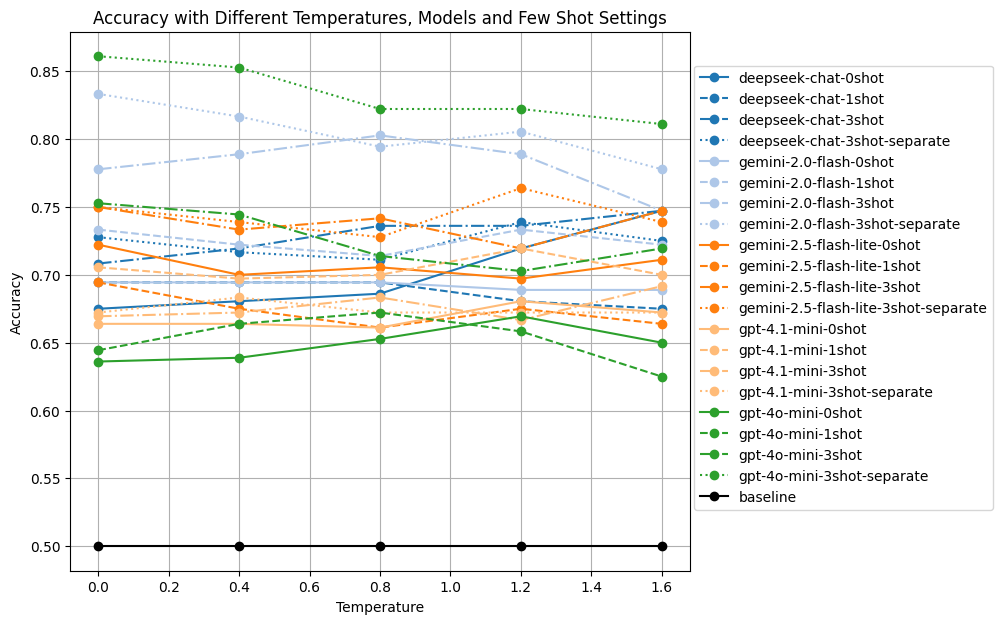

In [55]:
plt.figure(figsize=(8, 7))

linestyles = {
    "0": "solid",
    "1": "dashed",
    "3": "dashdot",
    "3s": "dotted"
}

model_list = df_model_acc_avg['model'].unique()
color_map = {model: plt.cm.tab20(i) for i, model in enumerate(model_list)}

for model in df_model_acc_avg['model'].unique():
    for few_shot in df_model_acc_avg['few shot'].unique():
        subset = df_model_acc_avg[(df_model_acc_avg['model'] == model) & (df_model_acc_avg['few shot'] == few_shot)]

        linestyle = linestyles.get(few_shot, "solid")
        color = color_map[model]
        
        if few_shot != '3s':
            shot_label = f"{few_shot}shot"
        else:
            shot_label = '3shot-separate'
        label = f"{model}-{shot_label}"
        
        plt.plot(subset['temperature'], subset['accuracy'], marker='o', linestyle=linestyle, color=color, label=label)

baseline_y = [0.5] * len(df_model_acc_avg['temperature'].unique())
baseline_x = sorted(df_model_acc_avg['temperature'].unique())

plt.plot(
    baseline_x,
    baseline_y,
    marker='o',
    linestyle="solid",
    color="black",
    label="baseline"
)

plt.xlabel('Temperature')
plt.ylabel('Accuracy')
plt.title('Accuracy with Different Temperatures, Models and Few Shot Settings')
plt.legend(bbox_to_anchor=(1.5, 0.95), loc='upper right')
plt.grid(True)
plt.show()

#### Separate

In [95]:
ZERO_SHOT_PROMPT_1 = f"""

<Prof>: 
{CONTEXT} \n

Currently we have the following 13 indices: \n
a. The first 2 indices are about methods being used, namely qualitative and quantitative. Note that a paper can use mixed methods (both of them). \n
b. The following 2 indices are about data being included in the study, namely social-demographic-economic data and environmental data, \
note that a paper can contain both or neither of them. \n
c. Then there are 5 indices about focal demographic groups of the study, namely individual, households, subnational groups, national groups, \
international groups. Note that a paper can focus on diverse groups of people. And please don't misunderstand, this is not the focal geographic areas of a paper. \n
e. Indices 10 and 11 are about the type of places where related interviews of the study took place, namely urban and rural. A study may focus on both, or neither. \n
f. Indices 12 and 13 are about time being considered: time frame means the paper focuses on temporal issues with for example, time series analysis, \
and foresight means the paper talks about forecast, prediction or perspective. A paper may consider both or neither of them. \n


Always keep the result in the following formality. Don't add anything else. \n
{{'Qualitative method': '_', 'Quantitative method': '_', 'Socio-demo-economic data': '_', 'Environmental data': '_', \
'Individuals': '_', 'Households': '_', 'Subnational groups': '_', 'National groups': '_', 'International groups': '_', \
'Urban': '_', 'Rural': '_', 'Time frame considered': '_', 'Foresight': '_'}} \n

Here for each '_' there should be a binary code, either '0' or '1'. Again, do not put any other thing there. \
It's possible that some information is missing, for example, a paper may not mention the research method used in the research at all, in this case, \
you should just put '0' for both of these indices.
"""

In [97]:
ZERO_SHOT_PROMPT_2 = f"""

<Prof>: 
{CONTEXT} \n

Currently we have the following 7 indices about environmental stressors being considered in a study: \n
'Rainfall pattern / Variability' (like the delay of rainy season, rather than floods or droughts), 'Temperature change', \
'Food scarcity / Famine / Food security', 'Drought / Aridity / Desertification', 'Floods', \
'Erosion / Soil fertilty / Land degradation / Deforestation / Salinisation', 'Self assessement / Perceived environment'. \
Note that the index 'self assessement or perception' is different from the other 6 indices about stressors. \
In other words, as long as data of those stressors are from human perception rather than observation, this index should have the value '1'.
About stressors, a paper can consider multiple or none of them. \n 

Always keep the result in the following formality. Don't add anything else. \n
{{'Rainfall pattern / Varibility': '_', 'Temperature change': '_', 'Food scarcity / Famine / Food security ': '_', 'Drought / Aridity / Desertification': '_', \
'Floods': '_', 'Erosion / Soil fertilty / Land degradation / Deforestation / Salinisation': '_', 'Self assessement / Perceived environment': '_'}} \n

Here for each '_' there should be a binary code, either '0' or '1'. Again, do not put any other thing there. \
It's possible that some information is missing, for example, a paper may not mention any environmental stressors specifically, in this case, \
you should just put '0' for both of these indices.
"""

In [100]:
ZERO_SHOT_PROMPT_3 = f"""

<Prof>: 
{CONTEXT} \n

Currently we have the following 8 indices about types of migration being included: \n
'Labour migration' (those related to work etc.), 'Marriage migration', \
'Refugees', 'International migration', 'Cross-border migration', 'Internal migration', 'Rural to urban' and 'Rural to rural'. Here 'cross border' usually \
means the migration from one nation to the adjacent nations, and 'international' leads to the migration with much longer distance. Note that a paper \
might contain multiple types of migration, and can contain none of them as well. \n

Always keep the result in the following formality. Don't add anything else. \n
{{'Labour migration': '_', 'Marriage migration': '_', 'Refugees': '_', 'International migration': '_', 'Cross-border migration': '_', 'Internal migration': '_', \
'Rural to urban': '_', 'Rural to rural': '_'}} \n

Here for each '_' there should be a binary code, either '0' or '1'. Again, do not put any other thing there. \
It's possible that some information is missing, for example, a paper may not mention specific migration types at all, in this case, \
you should just put '0' for both of these indices.
"""

In [102]:
ZERO_SHOT_PROMPT_4 = f"""

<Prof>: 
{CONTEXT} \n

Currently we have the following 5 indices about patterns of migration being included: \n
'Circular / Seasonal', 'Long distance', 'Short distance', 'Temporal', and 'Permanent'. Note that a paper can also consider multiple or none of them. \n

Always keep the result in the following formality. Don't add anything else. \n
{{'Circular / Seasonal': '_', 'Long distance': '_', 'Short distance': '_', 'Temporal': '_', 'Permanent': '_'}} \n

Here for each '_' there should be a binary code, either '0' or '1'. Again, do not put any other thing there. \
It's possible that some information is missing, for example, a paper may not mention the research method used in the research at all, in this case, \
you should just put '0' for both of these indices.
"""

In [103]:
ZERO_SHOT_PROMPT_5 = f"""

<Prof>: 
{CONTEXT} \n

Currently we have the following 3 indices about if specific demographic groups were focused on: \n
'Age', 'Gender', 'Ethnicity / Religion'. Note that a paper can also consider multiple or none of them. \n

Always keep the result in the following formality. Don't add anything else. \n
{{'Age': '_', 'Gender': '_', 'Ethnicity / Religion': '_'}} \n

Here for each '_' there should be a binary code, either '0' or '1'. Again, do not put any other thing there. \
It's possible that some information is missing, for example, a paper may not mention the research method used in the research at all, in this case, \
you should just put '0' for both of these indices.
"""

In [104]:
def extract_features_sep(paper: dict, example: bool, provider, model, temperature, part):

    fail_count = 0
    ZERO_SHOT_PROMPT_CURRENT = globals()[f"ZERO_SHOT_PROMPT_{part}"]
    FEW_SHOT_PROMPT_CURRENT = globals()[f"ZERO_SHOT_PROMPT_{part}"]
    while True:
        if example:
            prompt = f"""
            Please answer in a consistent style, performing the following actions step by step: \n
            1 - Read and understand the instructions and the examples, understand the professor's requirements and the research assistant's work on coding. \n
            2 - You will be provided with a paper. Please read and give your answer according to the professor's requirement \
            just as what the research assistant did. \n
            You just need to return the final result of step 2, and make it as Python dictionaty format as performed below. Do not explain reasoning. \n

            Here are the instructions and examples: \n"
            f"{FEW_SHOT_PROMPT_CURRENT}\n"
            Here is the new paper, please extract the required information like the research assistant: \n"
            f"{paper}\n"
            "Keep in mind that output format is Python dictionary, with no extra text."
            """

        elif not example:
            prompt = f"""
            Please answer in a consistent style, performing the following actions step by step: \n
            1 - Read and understand the instructions, understand the professor's requirements regarding coding. \n
            2 - You will be provided with a paper. Please read and give your answer according to the professor's requirement. \n
            You just need to return the final result of step 2, and make it as Python dictionaty format as performed below. Do not explain reasoning. \n

            Here are the instructions: \n"
            f"{ZERO_SHOT_PROMPT_CURRENT}\n"
            Here is the paper, please extract the required information: \n"
            f"{paper}\n"
            "Keep in mind that output format is Python dictionary, with no extra text."
            """

        response = get_completion(prompt, provider, model, temperature)
    
        if response.strip().startswith("```"):
            lines = response.splitlines()
            if lines and lines[0].startswith("```"):
                lines = lines[1:]
            if lines and lines[-1].startswith("```"):
                lines = lines[:-1]
            response = "\n".join(lines)
        response = response.strip()
    
        try:
            data = ast.literal_eval(response)
            return data, fail_count
        except Exception as e:
            fail_count += 1
            time.sleep(1)
            if fail_count >= 20:
                raise ValueError(f"Can't parse as Python dict: {response}, retried too many times") from e

    return data, fail_count

In [115]:
def extract_to_df_sep(literature: dict, example: bool, provider, model, part):
    results = []
    if provider == 'gemini':
        temperatures = np.round(np.arange(0.0, 1.0, 0.2), 1)
    else:
        temperatures = np.round(np.arange(0.0, 2.0, 0.4), 1)
        
    for t in temperatures:
        print (f"temperature:{t}")
        for run_id in range(20):
            success = False
            while not success:
                try:
                    features, _ = extract_features_sep(literature, example, provider, model, t, part)
                    features["provider"] = provider
                    features["model"] = model
                    features["few shot"] = example
                    features["temperature"] = t
                    features["run"] = run_id
                    results.append(features)
                    success = True
                except (openai.error.RateLimitError,
                        openai.error.APIError,
                        openai.error.ServiceUnavailableError,
                        openai.error.Timeout) as e:
                    time.sleep(4)


    df = pd.DataFrame(results)
    return df

In [111]:
def concat(literature: dict, example: bool, provider, model):
    dfs = {}
    for part in range(1,6):
        dfs[f"df_{part}"] = extract_to_df_sep(literature, example, provider, model, part)

    merged_df = pd.merge(dfs["df_1"], 
                         pd.merge(dfs["df_2"],
                                  pd.merge(dfs["df_3"],
                                           pd.merge(dfs["df_4"], dfs["df_5"], on=['provider', 'model', 'few shot', 'temperature', 'run'], how='inner'),
                                           on=['provider', 'model', 'few shot', 'temperature', 'run'], how='inner'),
                                  on=['provider', 'model', 'few shot', 'temperature', 'run'], how='inner'),
                         on=['provider', 'model', 'few shot', 'temperature', 'run'], how='inner')
    return merged_df

In [116]:
gemini_0_sep = concat(literature[0], False, 'gemini', 'gemini-2.0-flash')

temperature:0.0
temperature:0.2
temperature:0.4
temperature:0.6
temperature:0.8
temperature:0.0
temperature:0.2
temperature:0.4
temperature:0.6
temperature:0.8
temperature:0.0
temperature:0.2
temperature:0.4
temperature:0.6
temperature:0.8
temperature:0.0
temperature:0.2
temperature:0.4
temperature:0.6
temperature:0.8
temperature:0.0
temperature:0.2
temperature:0.4
temperature:0.6
temperature:0.8
